In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, file_utils, torch_utils, panda_baseline_models, panda_datasets

In [3]:
# Load dataset
trainset = panda_datasets.PandaSimpleDataset("data/pull-test.hdf5", use_prev_states=False)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

In [4]:
# Create model & training buddy
experiment_name = "no_prev_state"

model = panda_baseline_models.PandaBaselineModel()
buddy = torch_utils.TrainingBuddy(experiment_name, model)

Using device: cpu


AttributeError: module 'torch.utils' has no attribute 'tensorboard'

In [ ]:
# Define optimizer
def train(learning_rate=1e-5):
    # Set learning rate
    # print("Setting learning rate to", learning_rate)

    # Train for 1 epoch
    for batch_idx, batch in enumerate(trainset_loader):
        # Transfer to GPU and pull out batch data
        batch_gpu = torch_utils.to_device(batch, device)
        prev_states, observations, controls, new_states = batch_gpu

        new_states_pred = model(prev_states, observations, controls)
        
        mse_pos, mse_vel = torch.mean((new_states_pred - new_states) ** 2, axis=0)
        loss = (mse_pos + mse_vel) / 2

        buddy.minimize(loss)
        buddy.log("Training loss", loss)
        buddy.log("MSE position", mse_pos)
        buddy.log("MSE velocity", mse_vel)
        
        label_std = new_states.std(dim=0)
        assert prev_std.shape == (2,)
        buddy.log("Training pos std", label_std[0])
        buddy.log("Training vel std", label_std[1])
        
        pred_std = new_states_pred.std(dim=0)
        assert pred_std.shape == (2,)
        buddy.log("Predicted pos std", pred_std[0])
        buddy.log("Predicted vel std", pred_std[1])

In [ ]:
for i in range(100):
    print("Training epoch", i)
    train()

In [219]:
buddy.save_checkpoint()

Saved checkpoint to path: checkpoints/no_prev_state-1555.ckpt


In [220]:
def eval(model, trajectories):
    # To make things easier, we're going to cut all our trajectories to the same length :)
    timesteps = np.min([len(s) for s, _, _ in trajectories])
    predicted_states = [[states[0]] for states, _, _ in trajectories]
    actual_states = [states[:timesteps] for states, _, _ in trajectories]
    for t in range(1, timesteps):
        s = []
        o = {}
        c = []
        for i, traj in enumerate(trajectories):
            states, observations, controls = traj

            s.append(predicted_states[i][t - 1])
            o_t = torch_utils.DictIndexWrapper(observations)[t]
            torch_utils.DictIndexWrapper(o).append(o_t)
            c.append(controls[t])

        s = np.array(s)
        torch_utils.DictIndexWrapper(o).convert_to_numpy()
        c = np.array(c)

        pred = model(*torch_utils.to_torch([s, o, c]))
        pred = torch_utils.to_numpy(pred)
        assert pred.shape == (len(trajectories), 2)
        for i in range(len(trajectories)):
            predicted_states[i].append(pred[i])

    predicted_states = np.array(predicted_states)
    return predicted_states, actual_states


eval_trajectories = file_utils.load_trajectories("data/pull-test.hdf5")
pred, actual = eval(model, eval_trajectories[:3])

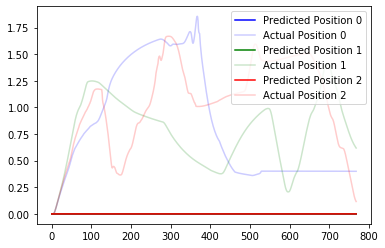

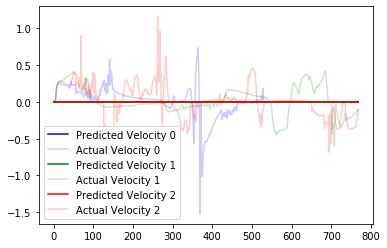

In [221]:
def vis_eval(predicted_states, actual_states):
    timesteps = len(actual_states[0])

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i, (pred, actual) in enumerate(zip(predicted_states, actual_states)):
        plt.plot(range(timesteps), pred[:,0], label="Predicted Position " + str(i), c=colors[i])
        plt.plot(range(timesteps), actual[:,0], label="Actual Position " + str(i), c=colors[i], alpha=0.2)
    plt.legend()
    plt.show()
    
    for i, (pred, actual) in enumerate(zip(predicted_states, actual_states)):
        plt.plot(range(timesteps), pred[:,1], label="Predicted Velocity " + str(i), c=colors[i])
        plt.plot(range(timesteps), actual[:,1], label="Actual Velocity " + str(i), c=colors[i], alpha=0.2)
    plt.legend()
    plt.show()

vis_eval(pred, actual)
